# Peetz Pre-Process
## Data import and quality control pipeline

In [14]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imp
import scipy.stats
import lzma
import pickle5 as pickle
import math
import glob
import scipy.io as sio
from scipy.optimize import curve_fit
from scipy.signal import argrelmin
import datetime
import warnings
warnings.filterwarnings("ignore")
import calendar
from icecream import ic
import csv
import matplotlib.animation as animation
import statsmodels.api as sm

%matplotlib inline

## Met Tower Data

In [15]:
filename="./Peetz_processed_data-master/Peetz_stability_data_updated_for_Jake_20210510.pkl"

df_stability=pd.read_pickle(filename)

wind_speed_60m=df_stability.met_ws_60m_ms
wind_direction_56m=df_stability.met_wdir_56m
wind_speed_80m=df_stability.LIDAR_ws_mean_80m
wind_direction_80m=df_stability.LIDAR_wd_mean_80m
Obukhov_length_10m=df_stability.L_10m_10min
# TI_60m=df_stability.TI_60m_cup
TI_60m=df_stability.TI_60m_cup_detrend  # use detrend and save to a separate file

## SCADA Data

In [16]:
scada_10min_mean=pd.read_pickle("./scada_data_mean_1min.pkl")
scada_10min_std=pd.read_pickle("./scada_data_std_1min.pkl")

yaw1_mean=scada_10min_mean.wkstb_offsetfilt_filtered_2
yaw2_mean=180-scada_10min_mean.wkstb_vn_vane_degree_filtered_2

yaw1_std=scada_10min_std.wkstb_offsetfilt_filtered_2
yaw2_std=scada_10min_std.wkstb_vn_vane_degree_filtered_2

steering_status_path="./turbine02_offset-staus.csv"

file=open(steering_status_path)
csvreader=csv.reader(file)
column_header=next(csvreader)
rows=[]
for row in csvreader:
    rows.append(row)
file.close()

df_steering_status=pd.DataFrame(data=rows, columns=column_header)
df_steering_status["time"]=pd.to_datetime(df_steering_status["time"])
df_steering_status["wkstb_enabled_2"]=pd.to_numeric(df_steering_status["wkstb_enabled_2"],errors='coerce')
df_steering_status.set_index('time', inplace=True)

steering_status=df_steering_status.wkstb_enabled_2

## Stability, Turbulence Intensity Parameters

In [17]:
L= df_stability[(10/df_stability.L_10m_10min > -2) &  (10/df_stability.L_10m_10min < 2)].L_10m_10min
TI_detrend=df_stability[(10/df_stability.L_10m_10min > -2) &  (10/df_stability.L_10m_10min < 2)].TI_60m_cup_detrend
TI_trend=df_stability[(10/df_stability.L_10m_10min > -2) &  (10/df_stability.L_10m_10min < 2)].TI_60m_cup

def bin_averaged(x0,y0,bin_number,lowerlimit,upperlimit,substract=0.001):
    from scipy import stats
    mask = ~np.isnan(x0) & ~np.isnan(y0)
    x=x0[mask]
    y=y0[mask]
    bins = np.linspace(lowerlimit-substract,upperlimit-substract,bin_number)
    #bins = np.linspace(1,26,bin_number)
    bin_centers = (bins [:-1] + bins [1:])/2
    bin_mean_shear, bin_edges, binnumber = stats.binned_statistic(x,y, statistic='mean', bins=bins)
    bin_median_shear, bin_edges, binnumber = stats.binned_statistic(x,y, statistic='median', bins=bins)
    bin_std_shear, bin_edges, binnumber = stats.binned_statistic(x,y, statistic='std', bins=bins)
    return bin_centers, bin_mean_shear, bin_median_shear, bin_std_shear

def remove_nan(x0,y0):
    mask = ~np.isnan(x0) & ~np.isnan(y0)
    x=x0[mask]
    y=y0[mask]
    return x,y

TI=TI_detrend

(array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

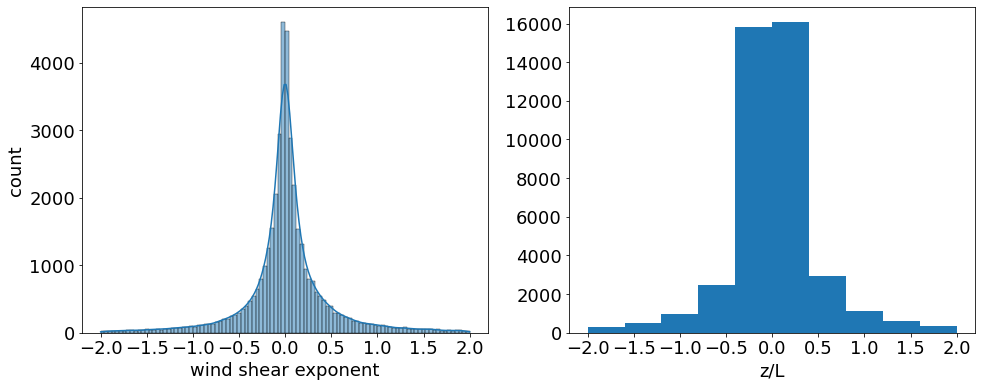

In [18]:
fig=plt.figure(figsize=(16,6))

ax=fig.add_subplot(122)
plt.hist(10/L)
plt.xlabel('z/L',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

ax=fig.add_subplot(121)
fig=sns.histplot(10/L.dropna(),bins=100,  kde=True)
plt.xlabel('wind shear exponent',fontsize=18)
plt.ylabel('count',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

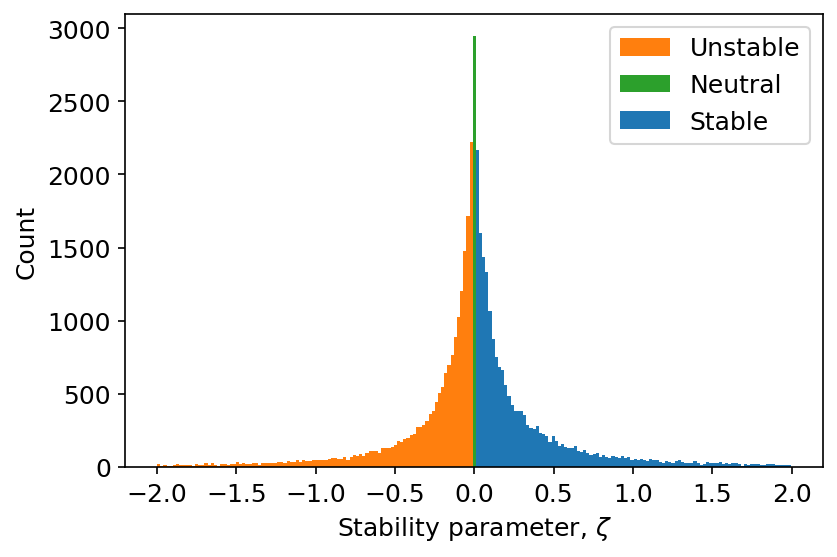

In [7]:
fig=plt.figure(figsize=(6,4), dpi=150)

plt.hist(10/df_stability.L_10m_10min[(10/df_stability.L_10m_10min < -0.01) & (10/df_stability.L_10m_10min > -2)], 100, color='C1', label='Unstable')
plt.hist(10/df_stability.L_10m_10min[(10/df_stability.L_10m_10min < 0.01) & (10/df_stability.L_10m_10min > -.01)], 1, color='C2', label='Neutral')
plt.hist(10/df_stability.L_10m_10min[(10/df_stability.L_10m_10min < 2) & (10/df_stability.L_10m_10min > .01)], 100, color='C0',label='Stable')
plt.legend(fontsize=12)
plt.xlabel('Stability parameter, $\zeta$',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

file_name = '/projects/jasi4471/peetz/Figures_Final_V1/stability_hist.pdf'
plt.savefig(file_name, bbox_inches='tight', format='pdf')

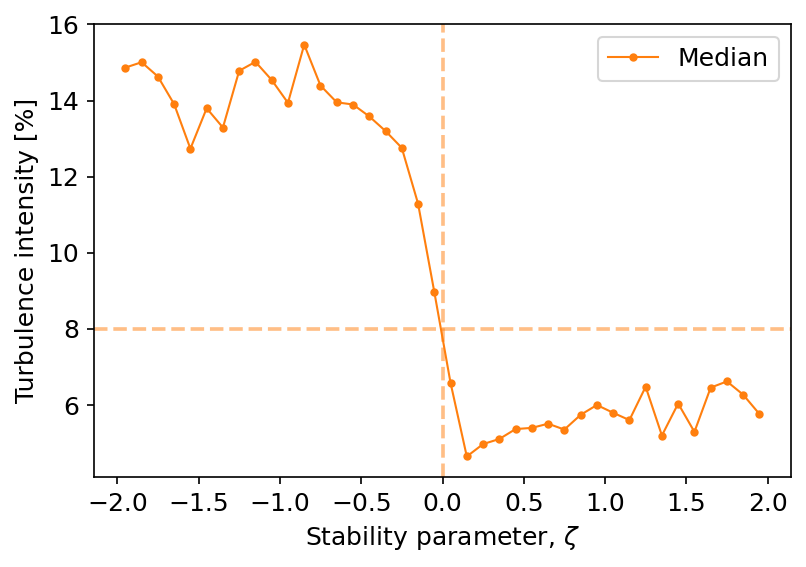

In [19]:
# fig=plt.figure(figsize=(6,4), dpi=150)
# plt.plot(10/L, TI,'.', markersize=6, color="C0", label='Samples')
# x0=10/L
# y0=TI
# lowerlimit=-2
# upperlimit=2
# bin_centers,bin_mean, bin_median, bin_std=bin_averaged(x0,y0,bin_number=41,lowerlimit=lowerlimit,upperlimit=upperlimit) 
# plt.plot(bin_centers,bin_median,'.-', lw=1, color="C1", label='Median')
# plt.xlabel('Stability parameter, $\zeta$',fontsize=12)
# plt.ylabel('Turbulence intensity [%]',fontsize=12)
# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)
# plt.ylim(0,25)
# plt.xlim(-1.5,1.5)
# plt.legend(fontsize=12)
# plt.axvline(x=0, ls='--', lw=1.75, color='C1', alpha=0.5)
# plt.axhline(y=8, ls='--', lw=1.75, color='C1', alpha=0.5)

fig=plt.figure(figsize=(6,4), dpi=150)
x0=10/L
y0=TI
lowerlimit=-2
upperlimit=2
bin_centers,bin_mean, bin_median, bin_std=bin_averaged(x0,y0,bin_number=41, lowerlimit=lowerlimit, upperlimit=upperlimit)
# plt.plot(x0, y0, '.', markersize=6, color="C0", label='Samples')
plt.plot(bin_centers,bin_median, '.-', lw=1, color="C1", label='Median')
plt.xlabel('Stability parameter, $\zeta$', fontsize=12)
plt.ylabel('Turbulence intensity [%]', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.ylim(0,25)
# plt.xlim(-1.5,1.5)
plt.legend(fontsize=12)
plt.axvline(x=0, ls='--', lw=1.75, color='C1', alpha=0.5)
plt.axhline(y=8, ls='--', lw=1.75, color='C1', alpha=0.5)


file_name = '/projects/jasi4471/peetz/Figures_Final_V1/TI_median.pdf'
plt.savefig(file_name, bbox_inches='tight', format='pdf')

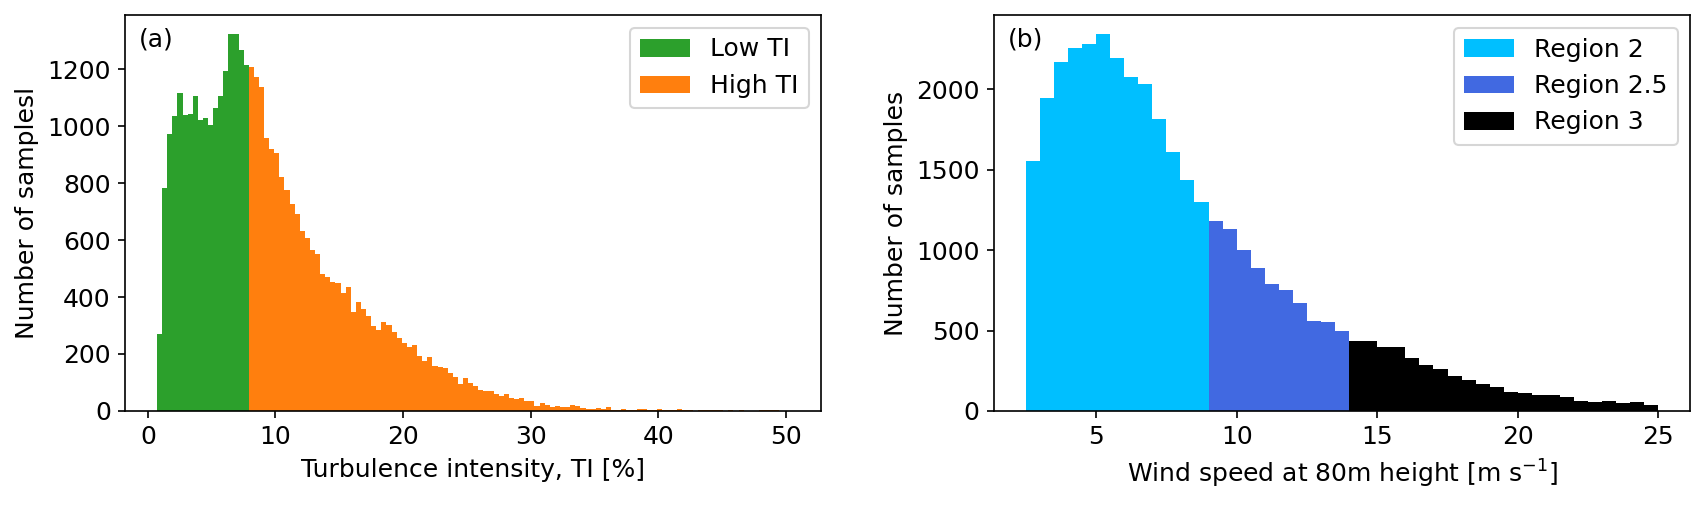

In [16]:
fig=plt.figure(figsize=(12,4), dpi=150)
ax=fig.add_subplot(121)
x=TI[TI<= 7.9].values
x1=TI[TI>= 7.9].values
index= x1> 50
x1[index]=np.nan
x1=x1[~np.isnan(x1)]
width=.4
bins=np.arange(x.min(), x.max()+width,width )
plt.hist(x, bins=bins, color="C2", label='Low TI')
bins=np.arange(x1.min(), x1.max()+width, width)
plt.hist(x1, bins=bins, color="C1", label='High TI')
plt.xlabel('Turbulence intensity, TI [%]', fontsize=12)
plt.ylabel('Number of samplesl', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.text(.02,.92, '(a)', fontsize=12, transform=ax.transAxes)

ax=fig.add_subplot(122)
x=df_stability.LIDAR_ws_mean_80m[(df_stability.LIDAR_ws_mean_80m < 9) & (df_stability.LIDAR_ws_mean_80m >= 2.5)]
x1=df_stability.LIDAR_ws_mean_80m[(df_stability.LIDAR_ws_mean_80m < 14) & (df_stability.LIDAR_ws_mean_80m >= 9)]
x2=df_stability.LIDAR_ws_mean_80m[(df_stability.LIDAR_ws_mean_80m >= 14) & (df_stability.LIDAR_ws_mean_80m < 25)]
width=.5
bins=np.arange(x.min(), x.max()+width,width )
plt.hist(x, bins=bins, color="deepskyblue", label='Region 2')
bins=np.arange(x1.min(), x1.max()+width, width)
plt.hist(x1, bins=bins, color="royalblue", label='Region 2.5')
bins=np.arange(x2.min(), x2.max()+width, width)
plt.hist(x2, bins=bins, color="black", label='Region 3')
plt.xlabel('Wind speed at 80m height [m s$^{-1}$]', fontsize=12)
plt.ylabel('Number of samples', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.text(.02,.92, '(b)', fontsize=12, transform=ax.transAxes)

fig.tight_layout(pad=3)

file_name = '/projects/jasi4471/peetz/Figures_Final_V1/TI_Region_distribution.pdf'
plt.savefig(file_name, bbox_inches='tight', format='pdf')

## Quality Control Pipeline

In [26]:
path="./hourly_processed_data_V1/"

ws_WC_list=[]
wd_WC_list=[]

ws_60m_list=[]
wd_60m_list=[]

yaw_offset_mean_list=[]
yaw_offset_std_list=[]
yaw_vane_mean_list=[]
yaw_vane_std_list=[]

scan_midtime_list=[]

TI_60m_list=[]
Obukhov_length_10m_list=[]

steering_status_list=[]

AWS_Vr_mat=pd.DataFrame()
WD_Vr_mat=pd.DataFrame()
CL_Vr_mat=pd.DataFrame()
WW_Vr_mat=pd.DataFrame()

AWS_Va_mat=pd.DataFrame()
WD_Va_mat=pd.DataFrame()
CL_Va_mat=pd.DataFrame()
WW_Va_mat=pd.DataFrame()

RMSE_Vr_mat=pd.DataFrame()
RMSE_Va_mat=pd.DataFrame()
Dif_Vr_mat=pd.DataFrame()
Dif_Va_mat=pd.DataFrame()

Dif_max_Vr_list=[]
Dif_max_Va_list=[]

no_of_scans_list=[]
nan_count_total_list = pd.DataFrame()
nan_count_list=[]
nan_count_curve_fit_list = pd.DataFrame()

# campaign_id = [60,61,68,72,78,82,83,84,85,86,87,88,89]      # For final
campaign_id = [60]      # For testing

for c in range(len(campaign_id)):
    
    campaign=campaign_id[c]
    
#     filenames=np.sort(glob.glob(path + "*" + '_hourly' + "*" + "%s" % (campaign) + "_Peetz" + "*"))  # All campaigns
    filenames=np.sort(glob.glob(path + "20190818_05_hourly_70*"))  # Select campaigns
###     filenames=np.sort(glob.glob(path + "20190914_12_hourly_70*"))  # Select campaigns
#     filenames=np.sort(glob.glob(path + "20190818_05_hourly_140*"))  # Select campaigns
          
    D=77                   

    for i,file in enumerate(filenames):
        print(file)
        
        with open(file, "rb") as fh:
            df = pickle.load(fh)
    
        unique_scan_id = file[46:54] # unique scan id

        Azimuth=df.Az.unique()
        Elevation=df.El.unique()
        Range_gate_number=len(np.unique(df.Range_gate))
        R=np.arange(9,18*len(np.unique(df.Range_gate)),18)

        yd, zd = np.meshgrid(R, Azimuth)
        Rt_y = yd*np.sin(zd/180*3.14)  # turn radial grid points into (x, y)
        Rt_x = yd*np.cos(zd/180*3.14)  # streamwise distance in meters

        no_of_scans=len(df.index)/len(df.index.unique()) # number of scan pattern wihtin an hour
        no_of_rays=len(Azimuth)
        
        no_of_scans_list.append(no_of_scans)

        #QC of the data
        df["Va"]=df.Doppler/(np.cos(np.deg2rad(df.El))*np.cos(np.deg2rad(180-df.Az)))
        df["Va_filtered"]=df["Va"].copy()
        df["Vr_filtered"]=df["Doppler"].copy()
        df["SNR_filtered"]=df["SNR"].copy()

        index_discard = (df["SNR"] < -18) | (df["SNR"] > 5) | (df.Doppler < 0)
        df.Vr_filtered[index_discard]=np.nan
        df["Va_filtered"]=df.Vr_filtered/(np.cos(np.deg2rad(df.El))*np.cos(np.deg2rad(180-df.Az)))
                            # df.Doppler/(np.cos(np.deg2rad(df.El))*np.cos(np.deg2rad(180-df.Az)))    # confirm that df.El is always zero

        multiindex_data=df.set_index(['Az', 'El', 'Range_gate'])

        for ii in [0]: # can take all the elevations
            df_mindex=multiindex_data.xs(ii,level=1)

            for j in range(int(no_of_scans)): # number of scans within the hour
                nrange2=[]
                AWS_Vr=[]
                WD_Vr=[]
                CL_Vr=[]
                WW_Vr=[]

                AWS_Va=[]
                WD_Va=[]
                CL_Va=[]
                WW_Va=[]
                
                RMSE_Vr_list=[]
                RMSE_Va_list=[]
                Dif_Vr_list=[]
                Dif_Va_list=[]

                Vr_mat=df_mindex['Vr_filtered'][len(Azimuth)*len(R)*j:len(Azimuth)*len(R)*(j+1)].unstack() # we have 2D mat data for a sigle scan
                Va_mat=df_mindex['Va_filtered'][len(Azimuth)*len(R)*j:len(Azimuth)*len(R)*(j+1)].unstack()
                SNR_mat=df_mindex['SNR_filtered'][len(Azimuth)*len(R)*j:len(Azimuth)*len(R)*(j+1)].unstack()
                Raytime_mat=df_mindex['Ray_time'][len(Azimuth)*len(R)*j:len(Azimuth)*len(R)*(j+1)].unstack()

                # getting the corresponding profliling lidar and scada data         
                scan_midtime_str=Raytime_mat[0].values[int(len(Azimuth)/2)]
                scan_midtime=datetime.datetime.strptime(scan_midtime_str,'%Y-%m-%d %H:%M:%S.%f')
                ind_ws_60m=np.argmin(abs(wind_speed_60m.index-scan_midtime))
                ind_ws_80m=np.argmin(abs(wind_speed_80m.index-scan_midtime))
                ind_yaw=np.argmin(abs(yaw1_mean.index-scan_midtime))
                ind_TI=np.argmin(abs(TI_60m.index-scan_midtime))
                ind_Obk=np.argmin(abs(Obukhov_length_10m.index-scan_midtime))
                ind_SS=np.argmin(abs(steering_status.index-scan_midtime))
                
                ws_60m=wind_speed_60m[ind_ws_60m]      # Wind speed from cup
                wd_56m=wind_direction_56m[ind_ws_60m]  # Wind direction from vane

                ws_80m=wind_speed_80m[ind_ws_80m]
                wd_80m=wind_direction_80m[ind_ws_80m]
                
                yaw_offset_mean=yaw1_mean[ind_yaw]
                yaw_offset_std=yaw1_std[ind_yaw]
                yaw_vane_mean=yaw2_mean[ind_yaw]
                yaw_vane_std=yaw2_std[ind_yaw]
                
                steering_status_temp=steering_status[ind_SS]
                
                if steering_status_temp == 0:
                    steering_status_label = "Off"
                elif steering_status_temp == 1:
                    steering_status_label = "On"
                else:
                    steering_status_label = "Error"

                TI_60m_temp=TI_60m[ind_TI]
                Obukhov_length_10m_temp=Obukhov_length_10m[ind_Obk]
                                
                ### 2D Plots of LOS and Horizontal Wakes

                label_sidechain=np.nan*Rt_y
                                            
                j = np.linspace(0, 20, 11, endpoint=True)
                l = np.linspace(0, 20, 6, endpoint=True)
                v = np.linspace(0, 20, 11, endpoint=True)
                q = np.linspace(0, 20, 6, endpoint=True)

#                 fig=plt.figure(figsize=(12,4), dpi=150)

#                 ax  = fig.add_subplot(121)
#                 ax=plt.contourf(Rt_x, Rt_y, Vr_mat, j, cmap='viridis')
#                 ax.ax.set_xticklabels(['Error',700,600,500,400,300,200,100,0])
#                 x = plt.colorbar(ticks=l)
#                 x.set_label('U$_L$$_O$$_S$ [m s$^{-1}$]',fontsize=12)
#                 plt.xlabel('Streamwise range [m]',fontsize=12)
#                 plt.ylabel('Spanwise range [m]',fontsize=12)
#                 plt.xlim(-750,0)
#                 plt.gca().invert_xaxis()
#                 plt.title('Yawed',fontsize=12)
# #                 plt.title('Line-of-sight Yawed',fontsize=12)
#                 plt.text(-14,180,'(a)',fontsize=12)
# #                 plt.text(-14,196,'(c)',fontsize=12)

#                 ax  = fig.add_subplot(122)
#                 ax=plt.contourf(Rt_x, Rt_y, Vr_mat, v, cmap='viridis')
#                 ax.ax.set_xticklabels(['Error',700,600,500,400,300,200,100,0])
#                 x = plt.colorbar(ticks=q)
#                 x.set_label('U$_L$$_O$$_S$ [m s$^{-1}$]',fontsize=12)
#                 plt.xlabel('Streamwise range [m]',fontsize=12)
#                 plt.ylabel('Spanwise range [m]',fontsize=12)
# #                 plt.title('Horizontal Unyawed',fontsize=12)
#                 plt.title('Unyawed',fontsize=12)
#                 plt.xlim(-750,0)
#                 plt.gca().invert_xaxis()
#                 plt.text(-14,180,'(b)',fontsize=12)
# #                 plt.text(-14,196,'(d)',fontsize=12)
                
#                 fig.tight_layout(pad=3)
            
# #                 file_name = '/projects/jasi4471/peetz/Figures_Final_V1/galion_unyawed.pdf'
#                 file_name = '/projects/jasi4471/peetz/Figures_Final_V1/galion_yawed.pdf'
#                 plt.savefig(file_name, bbox_inches='tight', format='pdf')


                for n in range(12):

                    N=3+n*18/D
                    r=np.argmin(abs(R-N*D))#+2 # specific streamwise range you want
                    nrange=r*(-18)
                    nrange2.append(r*(-18))

                    Vr=Vr_mat[r] # Vr has column range gates and index Azimuth
                    Vr_mean=np.mean(Vr)
                    Vr_min=np.min(Vr)
                    Vr_max=np.max(Vr)

                    Va=Va_mat[r]
                    Va_mean=np.mean(Va)
                    Va_min=np.min(Va)
                    Va_max=np.max(Va)

                    Az=Rt_y[:,r]        # spanwise distance in meters
                    Az_min=np.min(Az)
                    Az_max=np.max(Az)

                    plt.rcParams.update({'figure.max_open_warning': 0})
                    pd.options.mode.chained_assignment = None

                    nan_count=sum(np.isnan(Vr))
                    nan_count_list.append(nan_count)

                    if sum(np.isnan(Vr)) < 2:

                        Vr_org=Vr.copy()
                        Va_org=Va.copy()
                        Vr=pd.Series(Vr).interpolate(method='cubic').values
                        Va=pd.Series(Va).interpolate(method='cubic').values

                        if (np.isnan(Vr[0])==True): # first point is nan
                            Vr=pd.Series(Vr).interpolate(method='linear', limit_direction='backward').values
                            Va=pd.Series(Va).interpolate(method='linear', limit_direction='backward').values


                        Vr_min=np.min(Vr)
                        Vr_max=np.max(Vr)
                        Difference=np.float(Vr_max-Vr_min)
                        Centerline_loc=Az[np.argmin(Vr-Vr_min)]
                        Centerline_loc_left=Az[np.argsort(Vr-Vr_min)[0]]
                        Centerline_loc_right=Az[np.argsort(Vr-Vr_min)[1]]                      

                        Wake_width_guess=10
                        yaw_guess=0
                        
                        # Using Rt_y for Azimuth [sin(Az)]
                        # Azz = spanwise distance in meters guess, where azz is independent variable in fit (x)

                        try:
                            def gaussianVr(Azz, Ambient_windspeed, Wake_deficit, Wake_centerline, Wake_width, yaw):
                                return (Ambient_windspeed - Wake_deficit * np.exp(-(Azz - Wake_centerline)**2 / (2*Wake_width**2)))*(np.sqrt(R[r]**2-Azz**2)/R[r]*np.cos(yaw)-Azz/R[r]*np.sin(yaw)) # #yaw angle is in radian, your 'Azz' (y-cordinate) already  in m already

                            pars, cov = curve_fit(gaussianVr, Az, Vr, p0=[Va_max,Difference,Centerline_loc,Wake_width_guess,yaw_guess], bounds=(-np.inf, np.inf), maxfev=10000)
                            
                            # Az is the passed independent variable (x), Vr is the passed dependent variable (y), p0 is set of fitting parameter guesses
                            # Difference = wake deficit guess (in meters)
                            # yaw = wind direction (yaw angle of the turbine)

                            def doublegaussianVr(Azz, Ambient_windspeed, Wake_deficit, Centerline_left, Centerline_right, Wake_width, yaw):
                                return (Ambient_windspeed - Wake_deficit * (np.exp(-(Azz - Centerline_left)**2 / (2*Wake_width**2)) + (np.exp(-(Azz - Centerline_right)**2 / (2*Wake_width**2)))) *(np.sqrt(R[r]**2-Azz**2)/R[r]*np.cos(yaw)-Azz/R[r]*np.sin(yaw)))

                            pars2, cov2 = curve_fit(doublegaussianVr, Az, Vr, p0=[Va_max,Difference,Centerline_loc_left,Centerline_loc_right,Wake_width_guess,yaw_guess], bounds=(-np.inf, np.inf), maxfev=10000)
                            
                            Best_fit_line_Vr=gaussianVr(Az, *pars)
                            Best_fit_line_Va=doublegaussianVr(Az, *pars2)  ### REFERRING TO DOUBLE-GAUSSIAN AS BEST_FIT_LINE_VA -> and Va onwards...

                            #Variance of the fit
                            cov_Vr_max=np.max(np.diag(cov)) # max of four variables
                            cov_Vr_min=np.max(np.diag(cov)) # min of four variables
                            cov_Va_max=np.max(np.diag(cov2)) # max of four variables
                            cov_Va_min=np.max(np.diag(cov2)) # min of four variables
                            
                            cov_Vr_WD=pars[1]
                            cov_Vr_AWS=pars[0]
                            cov_Vr_CL=pars[2]
                            cov_Vr_WW=pars[3]
                            cov_Vr_yaw=pars[4]
                            
                            cov_Va_WD=pars2[1]
                            cov_Va_AWS=pars2[0]
                            cov_Va_CL=pars2[2]
                            cov_Va_WW=pars2[4]
                            cov_Vr_yaw=pars2[5]

                            #RMSE
#                             RMSE_Vr = np.sqrt(np.nanmean((Best_fit_line_Vr-Vr)**2))  ### These are the RMSE
#                             RMSE_Va = np.sqrt(np.nanmean((Best_fit_line_Va-Va)**2))
                            RMSE_Vr = sm.OLS(Best_fit_line_Vr, Vr).fit().f_pvalue  ### These are what we are using now for the extra sum-of-squares f-test
                            RMSE_Va = sm.OLS(Best_fit_line_Va, Va).fit().f_pvalue
                            print(RMSE_Vr)
                            print(RMSE_Va)
                            
                            Dif_Vr=abs(np.min(Vr)-np.min(Best_fit_line_Vr))
                            Dif_Va=abs(np.min(Va)-np.min(Best_fit_line_Va))
                            
                            Dif_max_Vr=abs(np.max(Vr)-np.max(Best_fit_line_Vr))   # Store this value in a DF!
                            Dif_max_Va=abs(np.max(Va)-np.max(Best_fit_line_Va))
                            
                            RMSE_Vr_list.append(RMSE_Vr)
                            RMSE_Va_list.append(RMSE_Va)
                            Dif_Vr_list.append(Dif_Vr)
                            Dif_Va_list.append(Dif_Va)
                            
                            #QC
                            if (Va_min < 0) | (pars[1] > pars[0]) | (pars[1] < 0) | (pars[3] < 18) | (pars[3] > 50):
                                
                                ### pars[0] = Ambient_windspeed
                                ### pars[1] = Wake_deficit
                                ### pars[2] = Wake_centerline
                                ### pars[3] = Wake_width
                                ### pars[4] = Ambient_wind_direction
                                ### Are AWS_Vr and WD_Vr defined ???

                                AWS_Vr.append(np.nan)
                                WD_Vr.append(np.nan)
                                CL_Vr.append(np.nan)
                                WW_Vr.append(np.nan)
                                
                            else:
                                AWS_Vr.append(pars[0])
                                WD_Vr.append(pars[1])
                                CL_Vr.append(pars[2])
                                WW_Vr.append(pars[3])

                            if (Va_min < 0) | (pars2[1] > pars2[0]) | (pars2[1] < 0) | (pars2[4] < 18) | (pars2[4] > 50):
                                
                                ### pars[0] = Ambient_windspeed
                                ### pars[1] = Wake_deficit
                                ### pars[2] = Centerline_left
                                ### pars[3] = Centerline_right
                                ### pars[4] = Wake_width
                                ### pars[4] = Ambient_winddirection

                                AWS_Va.append(np.nan)
                                WD_Va.append(np.nan)
                                CL_Va.append(np.nan)
                                WW_Va.append(np.nan)

                            else:
                                AWS_Va.append(pars2[0])
                                WD_Va.append(pars2[1])
                                CL_Va.append(pars2[2])
                                WW_Va.append(pars2[4])
                                
                                
                            label_sc_gaussian = np.nan*Best_fit_line_Va
                            
                            #  Gaussian Plots
#                             fig=plt.figure(figsize=(12,4), dpi=150)

#                             ax=fig.add_subplot(121)
# #                             ax=plt.plot(Az, Vr, '.', color='black', label="Observational data interpolated")
#                             plt.plot(Az, Vr_org, marker='o', color='black', label="Observations", markersize=10, markerfacecolor="None")
#                             plt.plot(Az, Best_fit_line_Vr, linestyle='-', linewidth=1.5, color='C3', label="Fitted values")
#                             plt.xlabel("Spanwise Range [m]",fontsize=12)
#                             plt.ylabel('U$_L$$_O$$_S$ [m s$^{-1}$]',fontsize=12)
# #                             plt.title('Line-of-sight Unyawed at 5D',fontsize=12)
#                             plt.title('Single-Gaussian at 3D',fontsize=12)
#                             plt.annotate('(a)', xy=(0.062,0.025), xycoords='axes fraction', fontsize=12, horizontalalignment='right', verticalalignment='bottom')
# #                             plt.annotate('(c)', xy=(0.06,0.025), xycoords='axes fraction', fontsize=12, horizontalalignment='right', verticalalignment='bottom')
#                             plt.legend(loc='lower right')

#                             ax=fig.add_subplot(122)
# #                             ax=plt.plot(Az, Va, '.', color='black', label="Observational data interpolated")
#                             plt.plot(Az, Va_org, marker='o', color='black', label="Observations", markersize=10, markerfacecolor="None")
#                             plt.plot(Az, Best_fit_line_Va, linestyle='-', linewidth=1.5, color='C3', label="Fitted values")
#                             plt.xlabel("Spanwise Range [m]",fontsize=12)
#                             plt.ylabel('U$_L$$_O$$_S$ [m s$^{-1}$]',fontsize=12)
# #                             plt.title('Horizontal Unyawed at 5D',fontsize=12)
#                             plt.title('Double-Gaussian at 3D',fontsize=12)
#                             plt.annotate('(b)', xy=(0.062,0.025), xycoords='axes fraction', fontsize=12, horizontalalignment='right', verticalalignment='bottom')
# #                             plt.annotate('(d)', xy=(0.062,0.025), xycoords='axes fraction', fontsize=12, horizontalalignment='right', verticalalignment='bottom')
#                             plt.legend(loc='lower right')
                            
#                             fig.tight_layout(pad=3)
            
# #                             file_name = '/projects/jasi4471/peetz/Figures_Final_V1/gaussian_3d.pdf'
# #                             file_name = '/projects/jasi4471/peetz/Figures_Final_V1/gaussian_unyawed_3d.pdf'
# #                             file_name = '/projects/jasi4471/peetz/Figures_Final_V1/gaussian_yawed_3d.pdf'
# #                             plt.savefig(file_name, bbox_inches='tight', format='pdf')

                            
                        except:

                            AWS_Vr.append(np.nan)
                            WD_Vr.append(np.nan)
                            CL_Vr.append(np.nan)
                            WW_Vr.append(np.nan)

                            AWS_Va.append(np.nan)
                            WD_Va.append(np.nan)
                            CL_Va.append(np.nan)
                            WW_Va.append(np.nan)
                            
                            RMSE_Vr_list.append(np.nan)
                            RMSE_Va_list.append(np.nan)
                            Dif_Vr_list.append(np.nan)
                            Dif_Va_list.append(np.nan)
                            
                            Dif_max_Vr=np.nan
                            Dif_max_Va=np.nan


                    else:
                        AWS_Vr.append(np.nan)
                        WD_Vr.append(np.nan)
                        CL_Vr.append(np.nan)
                        WW_Vr.append(np.nan)

                        AWS_Va.append(np.nan)
                        WD_Va.append(np.nan)
                        CL_Va.append(np.nan)
                        WW_Va.append(np.nan)

                        RMSE_Vr_list.append(np.nan)
                        RMSE_Va_list.append(np.nan)
                        Dif_Vr_list.append(np.nan)
                        Dif_Va_list.append(np.nan)
                        
                        Dif_max_Vr=np.nan
                        Dif_max_Va=np.nan
                        
                        
#                 ### Aggregate Plots

#                 fig=plt.figure(figsize=(16,4))

#                 ax=fig.add_subplot(121)
#                 ax=plt.plot(nrange2, WD_Vr, '--', color='orange', label="Velocity Deficit")
#                 plt.xlabel("Streamwise Range [m]",fontsize=14)
#                 plt.ylabel('V$_L$$_O$$_S$ [ms$^{-1}$]',fontsize=14)
#                 plt.title('Magnitude of Wake Deficit',fontsize=14)
#                 plt.xlim(-216,-414)
#                 plt.legend(loc='best')

#                 ax=fig.add_subplot(122)
#                 ax=plt.plot(nrange2, WD_Va, '--', color='orange', label="Velocity Deficit")
#                 plt.xlabel("Streamwise Range [m]",fontsize=14)
#                 plt.ylabel('U [ms$^{-1}$]',fontsize=14)
#                 plt.title('Magnitude of Wake Deficit',fontsize=14)
#                 plt.xlim(-216,-414)            
#                 plt.legend(loc='best')


#                 fig=plt.figure(figsize=(12,4))

#                 ax=fig.add_subplot(121)
#                 ax=plt.plot(nrange2, WW_Vr, '--', color='orange', label="Wake Width")
#                 plt.xlabel("Streamwise Range [m]",fontsize=14)
#                 plt.ylabel('V$_L$$_O$$_S$ Spanwise [m]',fontsize=14)
#                 plt.title('Magnitude of Wake Width',fontsize=14)
#                 plt.xlim(-216,-414)
#                 plt.legend(loc='best')

#                 ax=fig.add_subplot(122)
#                 ax=plt.plot(nrange2, WW_Va, '--', color='orange', label="Wake Width")
#                 plt.xlabel("Streamwise Range [m]",fontsize=14)
#                 plt.ylabel('U Spanwise [m]',fontsize=14)
#                 plt.title('Magnitude of Wake Width',fontsize=14)
#                 plt.xlim(-216,-414)            
#                 plt.legend(loc='best')
                
                
                nan_count_curve_fit = np.isnan(WD_Va)
                nan_count_curve_fit_list = pd.concat([nan_count_curve_fit_list, pd.Series(nan_count_curve_fit)], axis=1)

                
                if len(np.argwhere(np.isnan(AWS_Vr))) != 0:
                    lidar_toss_AWS_Vr = np.min(np.argwhere(np.isnan(AWS_Vr)))
                    AWS_Vr = pd.array(AWS_Vr)
                    AWS_Vr[lidar_toss_AWS_Vr:] = np.nan

                if len(np.argwhere(np.isnan(WD_Vr))) != 0:
                    lidar_toss_WD_Vr = np.min(np.argwhere(np.isnan(WD_Vr)))
                    WD_Vr = pd.array(WD_Vr)
                    WD_Vr[lidar_toss_WD_Vr:] = np.nan

                if len(np.argwhere(np.isnan(WD_Vr))) != 0:
                    lidar_toss_CL_Vr = np.min(np.argwhere(np.isnan(CL_Vr)))
                    CL_Vr = pd.array(CL_Vr)
                    CL_Vr[lidar_toss_CL_Vr:] = np.nan

                if len(np.argwhere(np.isnan(WD_Vr))) != 0:
                    lidar_toss_WW_Vr = np.min(np.argwhere(np.isnan(WW_Vr)))
                    WW_Vr = pd.array(WW_Vr)
                    WW_Vr[lidar_toss_WW_Vr:] = np.nan


                AWS_Vr_mat = pd.concat([AWS_Vr_mat, pd.Series(AWS_Vr)], axis=1)
                WD_Vr_mat = pd.concat([WD_Vr_mat, pd.Series(WD_Vr)], axis=1)
                CL_Vr_mat = pd.concat([CL_Vr_mat, pd.Series(CL_Vr)], axis=1)
                WW_Vr_mat = pd.concat([WW_Vr_mat, pd.Series(WW_Vr)], axis=1)


                if len(np.argwhere(np.isnan(AWS_Va))) != 0:
                    lidar_toss_AWS_Va = np.min(np.argwhere(np.isnan(AWS_Va)))
                    AWS_Va = pd.array(AWS_Va)
                    AWS_Va[lidar_toss_AWS_Va:] = np.nan

                if len(np.argwhere(np.isnan(WD_Va))) != 0:
                    lidar_toss_WD_Va = np.min(np.argwhere(np.isnan(WD_Va)))
                    WD_Va = pd.array(WD_Va)
                    WD_Va[lidar_toss_WD_Va:] = np.nan

                if len(np.argwhere(np.isnan(WD_Va))) != 0:
                    lidar_toss_CL_Va = np.min(np.argwhere(np.isnan(CL_Va)))
                    CL_Va = pd.array(CL_Va)
                    CL_Va[lidar_toss_CL_Va:] = np.nan

                if len(np.argwhere(np.isnan(WD_Va))) != 0:
                    lidar_toss_WW_Va = np.min(np.argwhere(np.isnan(WW_Va)))
                    WW_Va = pd.array(WW_Va)
                    WW_Va[lidar_toss_WW_Va:] = np.nan

                AWS_Va_mat = pd.concat([AWS_Va_mat, pd.Series(AWS_Va)], axis=1)
                WD_Va_mat = pd.concat([WD_Va_mat, pd.Series(WD_Va)], axis=1)
                CL_Va_mat = pd.concat([CL_Va_mat, pd.Series(CL_Va)], axis=1)
                WW_Va_mat = pd.concat([WW_Va_mat, pd.Series(WW_Va)], axis=1)

                nan_count_total = np.isnan(WD_Va)
                nan_count_total_list = pd.concat([nan_count_total_list, pd.Series(nan_count_total)], axis=1)

                scan_midtime_list.append(scan_midtime)

                ws_WC_list.append(ws_80m) 
                wd_WC_list.append(wd_80m)
                ws_60m_list.append(ws_60m) 
                wd_60m_list.append(wd_56m)
                
                yaw_offset_mean_list.append(yaw_offset_mean)
                yaw_offset_std_list.append(yaw_offset_std)
                yaw_vane_mean_list.append(yaw_vane_mean)
                yaw_vane_std_list.append(yaw_vane_std)
                steering_status_list.append(steering_status_temp)

                TI_60m_list.append(TI_60m_temp)
                Obukhov_length_10m_list.append(Obukhov_length_10m_temp)
                
#                 RMSE_Vr_list.append(RMSE_Vr)
#                 RMSE_Va_list.append(RMSE_Va)
#                 Dif_Vr_list.append(Dif_Vr)
#                 Dif_Va_list.append(Dif_Va)
                Dif_max_Vr_list.append(Dif_max_Vr)
                Dif_max_Va_list.append(Dif_max_Va)
                
                RMSE_Vr_mat = pd.concat([RMSE_Vr_mat, pd.Series(RMSE_Vr_list)], axis=1)
                RMSE_Va_mat = pd.concat([RMSE_Va_mat, pd.Series(RMSE_Va_list)], axis=1)
                Dif_Vr_mat = pd.concat([Dif_Vr_mat, pd.Series(Dif_Vr_list)], axis=1)
                Dif_Va_mat = pd.concat([Dif_Va_mat, pd.Series(Dif_Va_list)], axis=1)



print('done.')

./hourly_processed_data_V1/20190818_05_hourly_70_50_60_Peetz01.pkl
2.8902612018151575e-16
4.564225300350255e-17
8.109832693384144e-16
3.731687732762329e-15
5.803218028603323e-15
3.088126809931954e-13
3.097493136247277e-14
1.312326114661944e-16
1.100744000055913e-13
2.5281910895611677e-15
7.180991332733601e-14
3.2764686424805092e-15
1.4448776448457317e-13
1.0141776210905013e-13
5.939726674343106e-15
1.1614638374404097e-13
8.290299377195383e-15
5.828683221585985e-14
4.0232262302798945e-15
8.095816781528458e-15
1.1737875843773196e-11
4.423981808655487e-13
2.9257199839818346e-12
3.4504070862454525e-12
2.6061304297601598e-14
5.486255687501209e-16
2.9110207950619398e-15
5.5965178501848964e-15
1.2235095050762366e-14
5.760299825111236e-15
1.7967036377744095e-16
7.636595513069454e-16
6.331913056924638e-16
8.571009874364003e-14
1.8658476643605103e-14
2.3741446985004197e-13
2.6710713718373707e-16
2.1677144575221314e-15
1.7691298099733833e-14
8.534305280816135e-15
6.383184306378401e-15
1.036205863

In [11]:
# # Shape testing
print("AWS_Vr_mat: \n", np.shape(AWS_Vr_mat))
print("WD_Vr_mat: \n", np.shape(WD_Vr_mat))
print("CL_Vr_mat: \n", np.shape(CL_Vr_mat))
print("WW_Vr_mat: \n", np.shape(WW_Vr_mat))
print("AWS_Va_mat: \n", np.shape(AWS_Vr_mat))
print("WD_Va_mat: \n", np.shape(WD_Va_mat))
print("CL_Va_mat: \n", np.shape(CL_Va_mat))
print("WW_Va_mat: \n", np.shape(WW_Va_mat))
print("nrange2: \n", np.shape(nrange2))
print("ws_WC_list: \n", np.shape(ws_WC_list))
print("wd_WC_list: \n", np.shape(wd_WC_list))
print("yaw_offset_mean_list: \n", np.shape(yaw_offset_mean_list))
print("yaw_vane_mean_list: \n", np.shape(yaw_vane_mean_list))
print("yaw_offset_std_list: \n", np.shape(yaw_offset_std_list))
print("yaw_vane_std_list: \n", np.shape(yaw_vane_std_list))
print("scan_midtime_list: \n", np.shape(scan_midtime_list))
print("TI_60m_list: \n", np.shape(TI_60m_list))
print("Obukhov_length_10m_list: \n", np.shape(Obukhov_length_10m_list))
print("steering_status_list: \n", np.shape(steering_status_list))
print("RMSE_Vr: \n", np.shape(RMSE_Vr_list))
print("RMSE_Va: \n", np.shape(RMSE_Va_list))
print("Dif_Vr: \n", np.shape(Dif_Vr_list))
print("Dif_Va: \n", np.shape(Dif_Va_list))
print("Dif_max_Vr: \n", np.shape(Dif_max_Vr_list))
print("Dif_max_Va: \n", np.shape(Dif_max_Va_list))
print("Total_no_of_Data_Points: \n", round(sum(no_of_scans_list*12)))
print("Total_no_Tossed_SNR: \n", sum(nan_count_list))
print("Total_no_Tossed_Curve_Fit: \n", nan_count_curve_fit_list.values.sum())
print("Total_no_Tossed_Downwind: \n", (nan_count_total_list.values.sum()-sum(nan_count_list)+nan_count_curve_fit_list.values.sum()))
print("Total_no_Tossed: \n", nan_count_total_list.values.sum())
print("Total_no_Kept: \n", (round(sum(no_of_scans_list*12)) - nan_count_total_list.values.sum()))

AWS_Vr_mat: 
 (12, 8)
WD_Vr_mat: 
 (12, 8)
CL_Vr_mat: 
 (12, 8)
WW_Vr_mat: 
 (12, 8)
AWS_Va_mat: 
 (12, 8)
WD_Va_mat: 
 (12, 8)
CL_Va_mat: 
 (12, 8)
WW_Va_mat: 
 (12, 8)
nrange2: 
 (12,)
ws_WC_list: 
 (8,)
wd_WC_list: 
 (8,)
yaw_offset_mean_list: 
 (8,)
yaw_vane_mean_list: 
 (8,)
yaw_offset_std_list: 
 (8,)
yaw_vane_std_list: 
 (8,)
scan_midtime_list: 
 (8,)
TI_60m_list: 
 (8,)
Obukhov_length_10m_list: 
 (8,)
steering_status_list: 
 (8,)
RMSE_Vr: 
 (12,)
RMSE_Va: 
 (12,)
Dif_Vr: 
 (12,)
Dif_Va: 
 (12,)
Dif_max_Vr: 
 (8,)
Dif_max_Va: 
 (8,)
Total_no_of_Data_Points: 
 96
Total_no_Tossed_SNR: 
 5
Total_no_Tossed_Curve_Fit: 
 91
Total_no_Tossed_Downwind: 
 182
Total_no_Tossed: 
 96
Total_no_Kept: 
 0


In [15]:
# # Combine variables into one large DataFrame and print for review

post_QC_data = {'AWS_Vr_mat':AWS_Vr_mat,'WD_Vr_mat':WD_Vr_mat,'CL_Vr_mat':CL_Vr_mat,'WW_Vr_mat':WW_Vr_mat,
                'AWS_Va_mat':AWS_Va_mat,'WD_Va_mat':WD_Va_mat,'CL_Va_mat':CL_Va_mat,'WW_Va_mat':WW_Va_mat,
                'nrange2':nrange2,'ws_WC_80m':ws_WC_list,'wd_WC_80m':wd_WC_list,'ws_60m': ws_60m_list,
                'wd_60m':wd_60m_list, 'yaw_offset_mean_list':yaw_offset_mean_list,
                'yaw_offset_std_list':yaw_offset_std_list,'yaw_vane_mean_list':yaw_vane_mean_list,
                'yaw_vane_std_list':yaw_vane_std_list,'scan_midtime_list':scan_midtime_list,'TI_60m_list':TI_60m_list,
                'Obukhov_length_10m_list':Obukhov_length_10m_list,'RMSE_Vr_mat':RMSE_Vr_mat,'RMSE_Va_mat':RMSE_Va_mat,
                'Dif_Vr_mat':Dif_Vr_mat,'Dif_Va_mat':Dif_Va_mat,'Dif_max_Vr_list':Dif_max_Vr_list,
                'Dif_max_Va_list':Dif_max_Va_list,'Steering_status_list':steering_status_list
               }
post_QC_data

{'AWS_Vr_mat':             0          0         0     0     0   0     0     0     0     0  \
 0   16.894707  15.945194  5.662159  <NA>  <NA> NaN  <NA>  <NA>  <NA>  <NA>   
 1        <NA>  15.544259  5.502784  <NA>  <NA> NaN  <NA>  <NA>  <NA>  <NA>   
 2        <NA>  15.583882  5.409802  <NA>  <NA> NaN  <NA>  <NA>  <NA>  <NA>   
 3        <NA>   15.52596  5.560616  <NA>  <NA> NaN  <NA>  <NA>  <NA>  <NA>   
 4        <NA>  15.414632  5.730971  <NA>  <NA> NaN  <NA>  <NA>  <NA>  <NA>   
 5        <NA>  15.381997  7.075998  <NA>  <NA> NaN  <NA>  <NA>  <NA>  <NA>   
 6        <NA>  15.432309  7.190234  <NA>  <NA> NaN  <NA>  <NA>  <NA>  <NA>   
 7        <NA>   15.54939  6.316001  <NA>  <NA> NaN  <NA>  <NA>  <NA>  <NA>   
 8        <NA>       <NA>  5.594016  <NA>  <NA> NaN  <NA>  <NA>  <NA>  <NA>   
 9        <NA>       <NA>      <NA>  <NA>  <NA> NaN  <NA>  <NA>  <NA>  <NA>   
 10       <NA>       <NA>      <NA>  <NA>  <NA> NaN  <NA>  <NA>  <NA>  <NA>   
 11       <NA>       <NA>      <NA>  <

In [16]:
# # Save post QC DataFrame to pkl

output = open('./Batch_Jobs_V2/post_QC_data_IDAll_V1.pkl', 'wb')
pickle.dump(post_QC_data, output)
output.close()